# **Pokemon classifier model**

On this project, we are trying to make a machine learning model that can classify the three starters pokemon. We want a model that, given the image of one of the three,  can tell which one is it. To know how precise our model is, we will get the accuracy of our program.

# Importing fastai library to start our project

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 20.5MB/s 
     |████████████████████████████████| 194kB 54.8MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 1.2MB 43.8MB/s 
     |████████████████████████████████| 12.8MB 221kB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

# Using Azure Cloud Computing Service

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '73b78c679b5c496c87aabb7da0881f05')

We are using bing search engine to get the photos of our pokemon

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

As we are just classifying the starter pokemon, first we want to make sure the program is running appropriately. For that, we're searching only 'bulbasaur'

As this method search_images_bing can only find at most 150 images, this cell will give us an output of '150'

In [ ]:
results = search_images_bing(key, 'bulbasaur')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
dest = gdrive/'bulbasaur.jpg'
download_url(ims[0], dest)

Here, we are resizing our image to 128px 128px

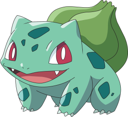

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

As we said before that we want to classify only starter pokemon, 'bulbasaur', 'charmander' and 'squirtle' will be the keyword. Then we will create three folders to save the images of each pokemon, named after each keyword.

In [ ]:
pokemon_types = 'bulbasaur','charmander','squirtle'
path = gdrive/'pokemons'

In [ ]:
if not path.exists():
    path.mkdir()
    for o in pokemon_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

Our folder has image files, as we'd expect:

In [ ]:
fns = get_image_files(path)
fns

(#359) [Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000004.png'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000001.PNG'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000005.png'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000009.jpg'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000003.jpg'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000000.jpg'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000010.png'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000002.png'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000007.png'),Path('/content/gdrive/My Drive/pokemons/bulbasaur/00000014.jpg')...]

Now we will check if there are any corrupted images and remove them.

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink);

Here, we are creating the datablock that we will be working with. It will get images and divide them into 2 groups. 20% of the images will be used for testing our model and the rest of them will be used for training. We are also resizing the images.

In [ ]:
pokemons = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

## Here are some methods for resizing and their outputs

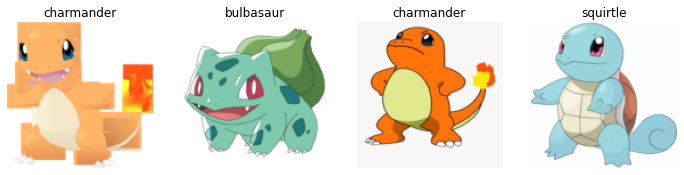

In [ ]:
pokemons = pokemons.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = pokemons.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

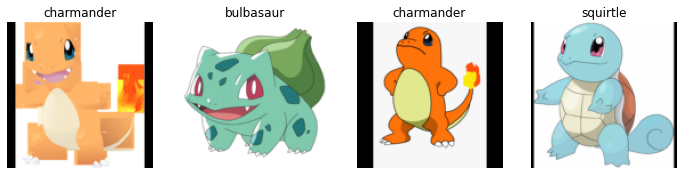

In [ ]:
pokemons = pokemons.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = pokemons.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

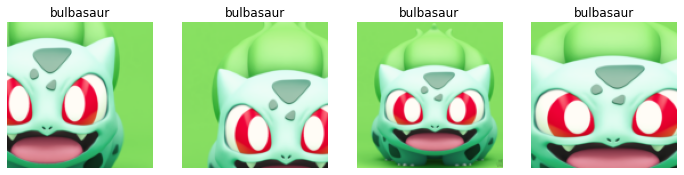

In [ ]:
pokemons = pokemons.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = pokemons.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

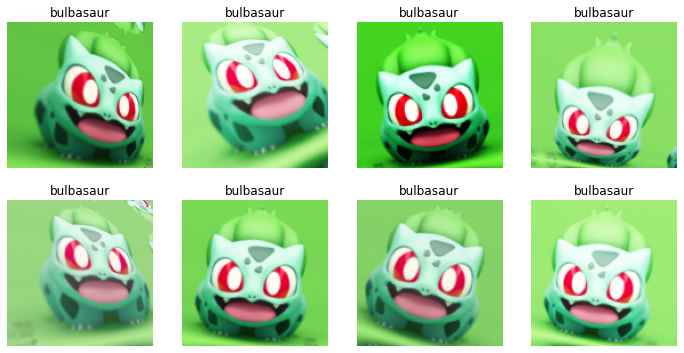

In [ ]:
pokemons = pokemons.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pokemons.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now we are actually starting the development of our model. First we will resize our images using the method RandomResizedCrop() into 224px that is common for images classification. And we are also using the default method aug_transforms() with the purpose of creating random variations of our input data.

In [ ]:
pokemons = pokemons.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pokemons.dataloaders(path)

Now we are training our model for the first time using resnet18. We are also ploting a graph to see where is the steepest point that we can use to get the best result from our model.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

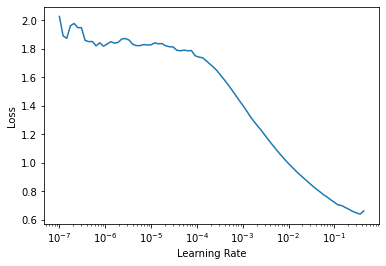

In [ ]:
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 3.63e-02, steepest point: 1.20e-03


Here, we are changing the base_lr value to one that will give us a better result.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

Now, we are ploting another graph with the new results of learning rate.

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=1.0964781722577754e-06)

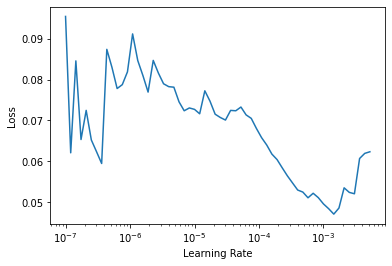

In [ ]:
learn.unfreeze()
learn.lr_find()

As we can in our graph, there're 2 peaks of learning rate, and we will get the value that is in the middle of these 2 peaks.


In [ ]:
learn.fit_one_cycle(6, lr_max=9e-4)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using discriminative learning rates.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

Here we are creating our confusion matrix that is a table used to describe our classification model's performance based on the test data which the labels are known.

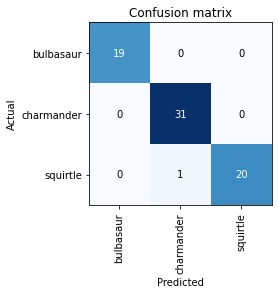

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We are going to see the 5 top losses of our model and check whether it's a problem of the data or with our model.

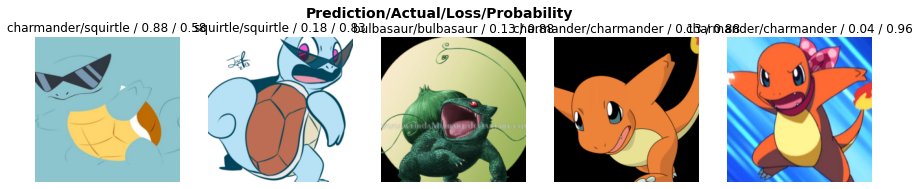

In [ ]:
interp.plot_top_losses(5, nrows=1)

After seeing the top losses, let's remove from our data images that don't have one of the 3 pokemons that we are trying to classify.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now that the data is clean, we are going to retrain our model.

In [ ]:
pokemons = pokemons.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pokemons.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


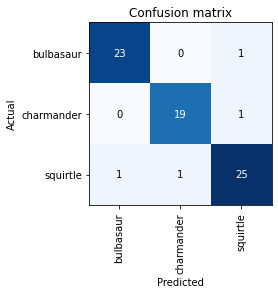

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

After retraining our model, we are going to export our results.

In [ ]:
learn.export(gdrive/'export.pkl')

To check if our export worked, let's load our model from GDrive, create a widget to upload images and check it with one image.

In [ ]:
path = gdrive
path.ls(file_exts='.pkl')

(#1) [Path('/content/gdrive/My Drive/export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: charmander; Probability: 0.9993')

At last, a widget is going to be recreated so images can be uploaded to check whether it is a bulbasaur, charmander or squirtle.

In [ ]:
btn_run = widgets.Button(description='Classify')

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your pokemon!'), 
      btn_upload, btn_run, out_pl, lbl_pred])